# Fit MCE data taken on TmVO4 samples
both in DR (plate-like sample) and in He3 (needles)

In [20]:
# Standard Python libraries
import os
from datetime import date
import sys

# Data analysis libraries
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Plotting libraries
import matplotlib
from matplotlib import cm, pyplot as plt, rcsetup, rc, rcParams
# cm stands for colormap

# Fitting libraries
from lmfit import minimize, Model, Parameters, report_fit, fit_report
from lmfit.models import LinearModel

In [8]:
for key in ['run', 'I', 'H', 'R', 'T', 'Tpuck', 'dH', 'Hraw', 'Traw',\
            'Hsmoothed', 'Tsmoothed']:
    if key not in locals():
        exec(f'{key}={{}}')

In [3]:
datFilePath = r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE'
os.chdir(datFilePath)
run[2] = pd.read_csv('Run2_0p5uA.dat', sep=', ')
I[2] = 5e-7# input current, in amps
run[2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,Time,Temperature(K),Field(T),LockinX(V),LockinY(V),Date = 7/29/2017 9:53 PM
0,9:53 PM,0.4000,-2.041789e-07,0.002116,-0.000070,NaN
1,9:53 PM,0.4001,-2.041789e-07,0.002116,-0.000070,NaN
2,9:53 PM,0.4000,-2.041789e-07,0.002114,-0.000070,NaN
3,9:53 PM,0.4000,-2.041789e-07,0.002110,-0.000069,NaN
4,9:53 PM,0.3999,-2.041789e-07,0.002110,-0.000070,NaN
...,...,...,...,...,...,...
72122,5:55 PM,0.7004,0.000000e+00,0.001069,-0.000014,NaN
72123,5:55 PM,0.7003,0.000000e+00,0.001069,-0.000014,NaN
72124,5:55 PM,0.7001,0.000000e+00,0.001069,-0.000014,NaN
72125,5:56 PM,0.7003,0.000000e+00,0.001069,-0.000014,NaN


In [4]:
run[2].columns

Index(['Time', 'Temperature(K)', 'Field(T)', 'LockinX(V)', 'LockinY(V)',
       'Date = 7/29/2017 9:53 PM'],
      dtype='object')

### Compute platform resistance
obtained from the voltage data $V_X$ of the X channel of the lock-in amplifier and the input electrical current $I$ as:
$$ R_\mathrm{platform} = V_X / I $$

In [5]:
Hraw[2] = run[2]['Field(T)']*1e4 # Magnetic field, in Oersted
Tpuck[2] = run[2]['Temperature(K)']# Puck (bath) temperature, in Kelvin
R[2] = run[2]['LockinX(V)']/I[2]# Platform resistance, in Volts

### Reproducing betamodel.mat
Which is the surface fit used in Matlab to convert the platform resistance data of the lockin to inverse temperature data:
$$ 1/T = \mathrm{betamodel}(V_X) $$

In [6]:
# The content of this cell was copy-pasted from the content of the 
# BetaModel sfit variable, as shown in Matlab after importing betamodel.mat

# Coefficients (with 95% confidence bounds):
p00 =     -0.2734#  (-0.2752, -0.2716)
p10 =    9.78e-06#  (8.802e-06, 1.076e-05)
p01 =      0.0011#  (0.001096, 0.001104)
p20 =   -4.45e-09#  (-5.037e-09, -3.862e-09)
p11 =  -1.322e-08#  (-1.427e-08, -1.216e-08)
p02 =  -2.275e-07#  (-2.305e-07, -2.246e-07)
p30 =   9.561e-13#  (7.765e-13, 1.136e-12)
p21 =   3.565e-12#  (3.342e-12, 3.789e-12)
p12 =   4.659e-12#  (4.225e-12, 5.092e-12)
p03 =    3.37e-11#  (3.272e-11, 3.468e-11)
p40 =  -8.502e-17#  (-1.093e-16, -6.072e-17)
p31 =  -6.191e-16#  (-6.464e-16, -5.918e-16)
p22 =   8.508e-17#  (4.041e-17, 1.298e-16)
p13 =  -6.088e-16#  (-6.86e-16, -5.316e-16)
p04 =  -2.724e-15#  (-2.872e-15, -2.577e-15)
p50 =   2.293e-21#  (1.105e-21, 3.48e-21)
p41 =   3.892e-20#  (3.749e-20, 4.034e-20)
p32 =   -1.77e-20#  (-1.973e-20, -1.567e-20)
p23 =   1.698e-21#  (-1.673e-21, 5.069e-21)
p14 =   2.632e-20#  (2.116e-20, 3.148e-20)
p05 =   8.741e-20#  (7.917e-20, 9.565e-20)

# Linear model Poly55:
def betamodel(x,y):
    """
    x: array
        Magnetic field data.
    y: array
        Platform resistance data.
    """
    val = p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 +\
    p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y \
    + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y \
    + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5
    return val

In [10]:
Traw[2] = 1/betamodel(Hraw[2],R[2])

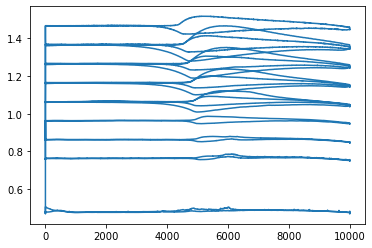

In [11]:
# Raw MCE traces
fig = plt.figure()
plt.plot(Hraw[2], Traw[2])

In [12]:
for tup in [(Hsmoothed, Hraw), (Tsmoothed, Traw)]:
    tup[0][2] = gaussian_filter1d(tup[1][2], 10)

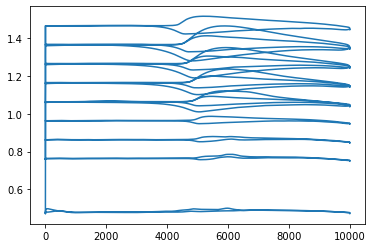

In [13]:
# Smoothed MCE traces
fig = plt.figure()
plt.plot(Hsmoothed[2], Tsmoothed[2])

In [14]:
dH[2] = np.diff(Hraw[2])

In [15]:
slow = 4#
fast = 10#
refsweep = np.mean([slow,fast])

In [16]:
for x in [(H, Hsmoothed), (T, Tsmoothed)]:
    for key in [2]:
        if key not in x[0].keys():
            x[0][key] = {}
        Xsmoothed = np.mean([x[1][key][:-1], x[1][key][1:]],0)
        x[0][key]['slow'] = Xsmoothed[dH[key]<refsweep]
        x[0][key]['fast'] = Xsmoothed[dH[key]>refsweep]

In [19]:
%matplotlib widget
fig = plt.figure()
for s in ['slow', 'fast']:
    plt.plot(H[2][s], T[2][s], '.')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [154]:
sys.path.append(r'C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts')
from MCE_simulations.mce_no_demag import mce_parameters, mce_residual